# Custom training: walkthrough

This sample uses machine learning to *categorize* Iris flowers by species. It uses TensorFlow to:

1. Build a model,
2. Train this model on example data, and
3. Use the model to make predictions about unknown data.


## TensorFlow programming

This guide uses these high-level TensorFlow concepts:

* Use TensorFlow's default [eager execution] development environment,
* Import data with the [Datasets API]
* Build models and layers with TensorFlow's [Keras API]

The workflow is:

1. Import and parse the dataset.
2. Select the type of model.
3. Train the model.
4. Evaluate the model's effectiveness.
5. Use the trained model to make predictions.

## Setup program

### Configure imports

Import TensorFlow and the other required Python modules. By default, TensorFlow uses [eager execution] to evaluate operations immediately, returning concrete values instead of creating a computational graph that is executed later. 

In [1]:
import os
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.7.0-dev20210715
Eager execution: True


## Import and parse the training dataset

Download the dataset file and convert it into a structure that can be used by this Python program.

### Download the dataset

Download the training dataset file using the `tf.keras.utils.get_file` function. This returns the file path of the downloaded file:

In [4]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

16384/2194 [================================================================================================================================================================================================================================] - 0s 0s/step
Local copy of the dataset file: C:\Users\Wei\.keras\datasets\iris_training.csv


### Inspect the data

This dataset, `iris_training.csv`, is a plain text file that stores tabular data formatted as comma-separated values (CSV). Use the `head -n5` command to take a peek at the first five entries:

In [5]:
!head -n5 {train_dataset_fp}

'head' is not recognized as an internal or external command,
operable program or batch file.


From this view of the dataset, notice the following:

1. The first line is a header containing information about the dataset:
  * There are 120 total examples. Each example has four features and one of three possible label names.
2. Subsequent rows are data records, one *[example](https://developers.google.com/machine-learning/glossary/#example)* per line, where:
  * The first four fields are *[features](https://developers.google.com/machine-learning/glossary/#feature)*: these are the characteristics of an example. Here, the fields hold float numbers representing flower measurements.
  * The last column is the *[label](https://developers.google.com/machine-learning/glossary/#label)*: this is the value we want to predict. For this dataset, it's an integer value of 0, 1, or 2 that corresponds to a flower name.

In [6]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


Each label is associated with string name (for example, "setosa"), but machine learning typically relies on numeric values. The label numbers are mapped to a named representation, such as:

* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica

In [7]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

### Create a `tf.data.Dataset`

TensorFlow's [Dataset API] handles many common cases for loading data into a model. This is a high-level API for reading data and transforming it into a form used for training. Since the dataset is a CSV-formatted text file, use the `tf.data.experimental.make_csv_dataset` function to parse the data into a suitable format. Since this function generates data for training models, the default behavior is to shuffle the data (`shuffle=True, shuffle_buffer_size=10000`), and repeat the dataset forever (`num_epochs=None`). 

In [8]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

The `make_csv_dataset` function returns a `tf.data.Dataset` of `(features, label)` pairs, where `features` is a dictionary: `{'feature_name': value}` These `Dataset` objects are iterable. 

In [9]:
features, labels = next(iter(train_dataset))

print(features)

OrderedDict([('sepal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([6.4, 6.5, 6.1, 7.7, 7.7, 6.1, 5.1, 6.4, 6.2, 6.2, 5.2, 6.5, 5.4,
       5.1, 5.8, 5.1, 5.4, 6.3, 6.8, 5. , 6.3, 5. , 4.9, 7.2, 5.7, 6.8,
       5.7, 6. , 5.4, 7.2, 6.3, 7.7], dtype=float32)>), ('sepal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([3.2, 3.2, 2.8, 3. , 2.8, 2.9, 2.5, 2.8, 2.8, 3.4, 3.5, 2.8, 3.4,
       3.8, 2.6, 3.5, 3. , 2.5, 2.8, 3.6, 3.4, 3.5, 3. , 3. , 3.8, 3.2,
       4.4, 2.2, 3.7, 3.2, 2.3, 3.8], dtype=float32)>), ('petal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([4.5, 5.1, 4. , 6.1, 6.7, 4.7, 3. , 5.6, 4.8, 5.4, 1.5, 4.6, 1.5,
       1.5, 4. , 1.4, 4.5, 5. , 4.8, 1.4, 5.6, 1.3, 1.4, 5.8, 1.7, 5.9,
       1.5, 5. , 1.5, 6. , 4.4, 6.7], dtype=float32)>), ('petal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([1.5, 2. , 1.3, 2.3, 2. , 1.4, 1.1, 2.1, 1.8, 2.3, 0.2, 1.5, 0.4,
       0.3, 1.2, 0.3, 1.5, 1.9, 1.4, 0.2, 2.4, 0.3, 0.2, 1.6,

Notice that like-features are grouped together, or *batched*. Each example row's fields are appended to the corresponding feature array. Change the `batch_size` to set the number of examples stored in these feature arrays.

To simplify the model building step, create a function to repackage the features dictionary into a single array with shape: `(batch_size, num_features)`. This function uses the `tf.stack` method which takes values from a list of tensors and creates a combined tensor at the specified dimension:

In [10]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

Then use the `tf.data.Dataset#map` method to pack the `features` of each `(features,label)` pair into the training dataset:

In [11]:
train_dataset = train_dataset.map(pack_features_vector)

The features element of the `Dataset` are now arrays with shape `(batch_size, num_features)`. 

In [12]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[6.5 3.2 5.1 2. ]
 [4.9 3.1 1.5 0.1]
 [6.7 3.  5.  1.7]
 [6.8 3.2 5.9 2.3]
 [5.7 2.9 4.2 1.3]], shape=(5, 4), dtype=float32)


## Select the type of model

### Create a model using Keras

The TensorFlow `tf.keras` API is the preferred way to create models and layers. This makes it easy to build models and experiment while Keras handles the complexity of connecting everything together.

The `tf.keras.Sequential` model is a linear stack of layers. Its constructor takes a list of layer instances, in this case, two `tf.keras.layers.Dense` layers with 10 nodes each, and an output layer with 3 nodes representing our label predictions. The first layer's `input_shape` parameter corresponds to the number of features from the dataset, and is required:

In [13]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

The *[activation function]* determines the output shape of each node in the layer. These non-linearities are important—without them the model would be equivalent to a single layer. There are many `tf.keras.activations`, but [ReLU] is common for hidden layers.

### Using the model

In [14]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-1.0351323 ,  0.50886434,  0.9543496 ],
       [-0.09910603,  0.470369  ,  0.69019413],
       [-0.88053334,  0.5260844 ,  1.0112379 ],
       [-1.1186546 ,  0.53806996,  1.1082311 ],
       [-0.720509  ,  0.4780327 ,  0.8319516 ]], dtype=float32)>

Here, each example returns a [logit] for each class. To convert these logits to a probability for each class, use the [softmax] function:

In [15]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.07695258, 0.3603898 , 0.56265765],
       [0.20123988, 0.35565913, 0.44310105],
       [0.08537355, 0.34850556, 0.56612086],
       [0.0644618 , 0.33791608, 0.59762216],
       [0.11063957, 0.36680105, 0.52255934]], dtype=float32)>

Taking the `tf.argmax` across classes gives us the predicted class index. But, the model hasn't been trained yet, so these aren't good predictions:

In [16]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
    Labels: [2 0 1 2 1 2 2 1 2 0 1 0 1 1 0 2 1 1 0 1 2 2 2 0 0 0 1 2 0 0 2 2]


## Train the model

### Define the loss and gradient function

Both training and evaluation stages need to calculate the model's *[loss]*. This measures how off a model's predictions are from the desired label, in other words, how bad the model is performing. We want to minimize, or optimize, this value.

Our model will calculate its loss using the `tf.keras.losses.SparseCategoricalCrossentropy` function which takes the model's class probability predictions and the desired label, and returns the average loss across the examples.

In [17]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [18]:
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 1.0362160205841064


Use the `tf.GradientTape` context to calculate the *[gradients]* used to optimize the model:

In [19]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

### Create an optimizer

In [20]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [21]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 0, Initial Loss: 1.0362160205841064
Step: 1,         Loss: 1.0069941282272339


### Training loop

A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

1. Iterate each *epoch*. An epoch is one pass through the dataset.
2. Within an epoch, iterate over each example in the training `Dataset` grabbing its *features* (`x`) and *label* (`y`).
3. Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use an `optimizer` to update the model's variables.
5. Keep track of some stats for visualization.
6. Repeat for each epoch.

The `num_epochs` variable is the number of times to loop over the dataset collection. 

In [22]:
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.004, Accuracy: 40.000%
Epoch 050: Loss: 0.437, Accuracy: 86.667%
Epoch 100: Loss: 0.260, Accuracy: 95.833%
Epoch 150: Loss: 0.184, Accuracy: 96.667%
Epoch 200: Loss: 0.130, Accuracy: 98.333%


### Visualize the loss function over time

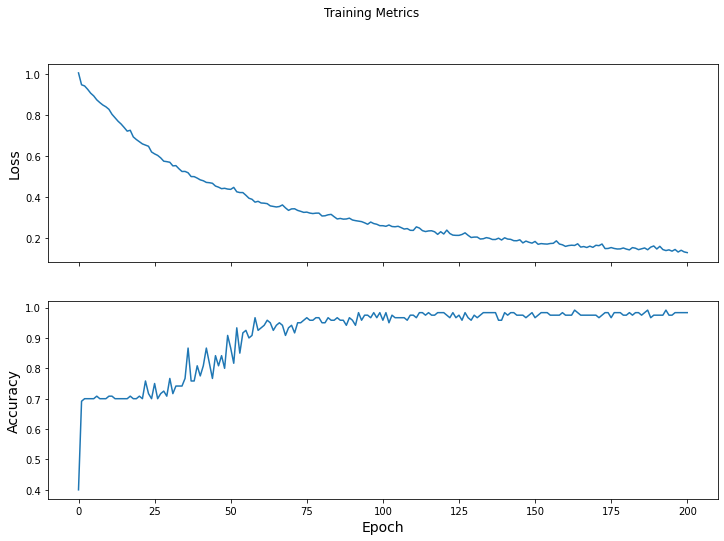

In [23]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## Evaluate the model's effectiveness

### Setup the test dataset

Evaluating the model is similar to training the model. The biggest difference is the examples come from a separate *[test set](https://developers.google.com/machine-learning/crash-course/glossary#test_set)* rather than the training set. To fairly assess a model's effectiveness, the examples used to evaluate a model must be different from the examples used to train the model.

The setup for the test `Dataset` is similar to the setup for training `Dataset`. Download the CSV text file and parse that values, then give it a little shuffle:

In [24]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

16384/573 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0s/step


In [25]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

### Evaluate the model on the test dataset

Unlike the training stage, the model only evaluates a single [epoch](https://developers.google.com/machine-learning/glossary/#epoch) of the test data. In the following code cell, we iterate over each example in the test set and compare the model's prediction against the actual label. This is used to measure the model's accuracy across the entire test set:

In [28]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


We can see on the last batch, for example, the model is usually correct:

In [29]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]], dtype=int32)>

## Use the trained model to make predictions

In [26]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

# training=False is needed only if there are layers with different
# behavior during training versus inference (e.g. Dropout).
predictions = model(predict_dataset, training=False)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (97.3%)
Example 1 prediction: Iris versicolor (86.0%)
Example 2 prediction: Iris virginica (85.8%)
